# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn.  Churn is where
a customer leaves the mobile provider.   The goal is to build a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook is to try to build and evaluate a __predictive model for churn__ - predict the value of the CHURN_IND field in the data from some of the other fields.  Note that the three `RECON` fields should not be used as they indicate whether the customer reconnected after having churned. 

__Note:__ you are not being evaluated on the _accuracy_ of the model but on the _process_ that you use to generate it.  You can use a simple model such as Logistic Regression for this task or try one of the more advanced methods covered in recent weeks.  Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings("ignore")

In [2]:
churn = pd.read_csv("files/MobileCustomerChurn.csv", na_values=["NA", "#VALUE!"], index_col='INDEX')
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,...,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,NaN,NaN,NaN
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,...,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,NaN,NaN,NaN
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,...,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,NaN,NaN,NaN
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,...,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,NaN,NaN,NaN
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,...,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,NaN,NaN,NaN


In [3]:
churn.shape

(46206, 21)

In [4]:
churn.describe()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
count,46206.000000,46206.000000,46206.000000,46130.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,28416.000000,28416.000000,28416.000000
mean,42335.196879,45.874627,1.555707,41.411836,50.318617,51.364858,10.846708,8.237112,20.349825,15.249968,0.385015,75.188029,0.014640,0.191125,0.007038
std,22100.432751,33.077927,0.835529,15.263726,51.925537,20.855419,9.769887,8.341476,8.034631,10.982958,0.486604,73.519041,0.120108,0.393194,0.083600
min,1.000000,0.000000,1.000000,-4.000000,0.000000,8.180000,0.000000,0.000000,0.000000,0.000000,0.000000,1.020000,0.000000,0.000000,0.000000
25%,24951.750000,14.000000,1.000000,28.000000,11.000000,36.360000,3.000000,0.000000,24.000000,0.000000,0.000000,36.360000,0.000000,0.000000,0.000000
50%,43261.000000,44.000000,1.000000,40.000000,35.000000,54.540000,8.000000,7.000000,24.000000,24.000000,0.000000,54.540000,0.000000,0.000000,0.000000
75%,61132.750000,77.000000,2.000000,52.000000,69.000000,72.720000,16.000000,16.000000,24.000000,24.000000,1.000000,84.530000,0.000000,0.000000,0.000000
max,79500.000000,120.000000,4.000000,116.000000,259.000000,234.540000,147.000000,24.000000,36.000000,36.000000,1.000000,1965.890000,1.000000,1.000000,1.000000


In [5]:
set(churn["CHURN_IND"])

{0, 1}

In [6]:
churn["CHURN_IND"].value_counts()

0    28416
1    17790
Name: CHURN_IND, dtype: int64

The data is unbalanced since the samples in both CHURN_IND values are not equal. There is a chance our model will be skewed and hence should be interpreted with caution.

### Dealing with NaN Values

In [7]:
churn.isna().sum()

CUST_ID                             0
ACCOUNT_TENURE                      0
ACCT_CNT_SERVICES                   0
AGE                                76
CFU                                 0
SERVICE_TENURE                      0
PLAN_ACCESS_FEE                     0
BYO_PLAN_STATUS                     0
PLAN_TENURE                         0
MONTHS_OF_CONTRACT_REMAINING        0
LAST_FX_CONTRACT_DURATION           0
CONTRACT_STATUS                     0
PREV_CONTRACT_DURATION              0
HANDSET_USED_BRAND                  0
CHURN_IND                           0
MONTHLY_SPEND                       0
COUNTRY_METRO_REGION                1
STATE                               1
RECON_SMS_NEXT_MTH              17790
RECON_TELE_NEXT_MTH             17790
RECON_EMAIL_NEXT_MTH            17790
dtype: int64

In [8]:
#Dropping all recon columns since we don't use it to predict the churn
churn2 = churn.drop(['RECON_SMS_NEXT_MTH', 'RECON_TELE_NEXT_MTH','RECON_EMAIL_NEXT_MTH'], axis=1)

In [9]:
churn2.isna().sum()

CUST_ID                          0
ACCOUNT_TENURE                   0
ACCT_CNT_SERVICES                0
AGE                             76
CFU                              0
SERVICE_TENURE                   0
PLAN_ACCESS_FEE                  0
BYO_PLAN_STATUS                  0
PLAN_TENURE                      0
MONTHS_OF_CONTRACT_REMAINING     0
LAST_FX_CONTRACT_DURATION        0
CONTRACT_STATUS                  0
PREV_CONTRACT_DURATION           0
HANDSET_USED_BRAND               0
CHURN_IND                        0
MONTHLY_SPEND                    0
COUNTRY_METRO_REGION             1
STATE                            1
dtype: int64

In [10]:
churn_clean = churn2.dropna()

In [11]:
churn_clean["CHURN_IND"].value_counts()

0    28366
1    17763
Name: CHURN_IND, dtype: int64

Since the number of NaN values were less as compared to the total dataset, we can drop these NaN rows. We see that 50 rows with CHURN_IND as 0 got dropped and 27 with CHURN_IND as 1 got dropped. This should not affect our model too much.

## Splitting Test and Train Data

In [12]:
# Split your data into training(80%) and testing data (20%) and use random_state=42

train, test = train_test_split(churn_clean, test_size=0.2, random_state=42)
print(train.shape)
print(test.shape)

(36903, 18)
(9226, 18)


In [13]:
X_train = train.drop(['CHURN_IND', 'CUST_ID', 'CFU', 'BYO_PLAN_STATUS', 'CONTRACT_STATUS', 'HANDSET_USED_BRAND', 'COUNTRY_METRO_REGION', 'STATE'], axis=1)
y_train = train['CHURN_IND']
X_test = test.drop(['CHURN_IND', 'CUST_ID', 'CFU', 'BYO_PLAN_STATUS', 'CONTRACT_STATUS', 'HANDSET_USED_BRAND', 'COUNTRY_METRO_REGION', 'STATE'], axis=1)
y_test = test['CHURN_IND']

While we could replace the categorical text data with values, it can cause some bias since we do not have a clear understanding on how the data is collected. Hence we dropping all the text data.


## Initial model using all non-text features

In [14]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [15]:
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

In [16]:
print("Accuracy score on training set: ", accuracy_score(y_train, y_hat_train))
print("Accuracy score on testing set: ", accuracy_score(y_test, y_hat_test))

Accuracy score on training set:  0.7102945559981574
Accuracy score on testing set:  0.7035551701712551


In [17]:
print(confusion_matrix(y_test, y_hat_test))

[[4606 1071]
 [1664 1885]]


### Analysis

Our model has an accuracy score of 70.36% and we got a confusion matrix on our test data as follows:

||Predicted 0|Predicted 1|Total Actual||
|---|---|---|---|---|
|Actual 0|4606 |1071|5677|(Actual 0)
|Actual 1|1664 |1885|3549|(Actual 1)
|Total Predicted|6270|2956|9226|Total Population
||(Predicted 0)|(Predicted 1)|Total Population|


As we can see we our Error rate is (1071+1664)/9226 = 0.296.

Our model is not accurate enough in predicting the Churn data for this mobile company.

## RFE method to find the best features

In [18]:
#creating RFE Object

lr_model = LogisticRegression(solver='lbfgs', max_iter=1000)
rfe = RFE(estimator = lr_model, n_features_to_select=6, step=1)
rfe.fit(X_train, y_train)

RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=6)

In [19]:
y_hat_test_rfe = rfe.predict(X_test)
print("Accuracy score on testing set with RFE: ", accuracy_score(y_test, y_hat_test_rfe))

Accuracy score on testing set with RFE:  0.700628658140039


In [20]:
#summarise all features

for i in range(X_train.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected False, Rank: 2.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected False, Rank: 5.000
Column: 4, Selected False, Rank: 3.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected False, Rank: 4.000
Column: 9, Selected True, Rank: 1.000


### Analysis

If we only select 6 features out of 10, we get an Accuracy Score of 69.98%. The 6 best features selected were:

1) ACCOUNT_TENURE

2) AGE

3) PLAN_TENURE

4) MONTHS_OF_CONTRACT_REMAINING

5) LAST_FX_CONTRACT_DURATION

6) MONTHLY_SPEND                   

## Finding accuracy scores for different number of features

In [21]:
#to increment number of features, one at a time

acc_scores = []
for i in range(1,11):
    clf = LogisticRegression(solver='lbfgs', max_iter=1000)
    rfe = RFE(estimator=clf, n_features_to_select=i)
    # training model
    
    rfe.fit(X_train, y_train)
    # predicting on test set
    
    y_pred = rfe.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    # print this
    
    print("Acc on test set using", i, "features: ", acc_score)
    # append to the list
    
    acc_scores.append(acc_score)

Acc on test set using 1 features:  0.6285497507045307
Acc on test set using 2 features:  0.6582484283546499
Acc on test set using 3 features:  0.6617168870583134
Acc on test set using 4 features:  0.6641014524170822
Acc on test set using 5 features:  0.6997615434641231
Acc on test set using 6 features:  0.700628658140039
Acc on test set using 7 features:  0.7012789941469759
Acc on test set using 8 features:  0.7024712768263602
Acc on test set using 9 features:  0.7027964448298287
Acc on test set using 10 features:  0.7035551701712551


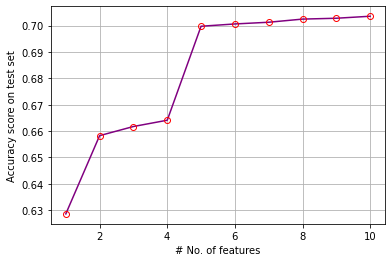

In [24]:
#Estimating accuracy score on test set using RFE by using different number of features

estimator = LogisticRegression(solver='lbfgs', max_iter=1000)
acc_scores = []
for i in range(1, 11):
    selector = RFE(estimator, i)
    selector = selector.fit(X_train, y_train)
    supp = selector.get_support()

    predicted = selector.predict(X_test)
    acc_score = accuracy_score(y_test, predicted)
    acc_scores.append(acc_score)
  
best = 1
for item in acc_scores:
    if item < acc_scores[best - 1]:
        best = acc_scores.index(item) + 1

plt.grid()   
plt.xlabel('# No. of features')
plt.ylabel('Accuracy score on test set')
plt.plot(range(1, 11), acc_scores, marker = 'o', color = 'purple', markeredgewidth = 1 ,markeredgecolor = 'red', markerfacecolor = 'None')
plt.show()

### Analysis

From the above graph we see that more features used is increasing our accuracy score with all(10) features giving the best accuracy score of 70.36%.

## Conclusion

From the analysis above it is clear that our model is not the most accurate and there could be further external factors (not in the gathered data) influencing a customer's decision to leave this mobile service company which could even be a better deal from a rival mobile service company. However our model can still predict with 70.36% accuracy on whether a customer might leave or not based on the data that can be collected in the company